In [41]:
from torch import nn
import torch

class ErrorEstimator(nn.Module):

    def __init__(self, in_channels, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_channels, hidden_size=hidden_size, num_layers=4,
                            batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x, _ = self.lstm(x)
        x = self.proj(x)
        x = torch.transpose(x, 1, 2)
        return x

x = torch.randn(3, 30, 100)
m = ErrorEstimator(30, 64)
y = m(x)
y.shape

torch.Size([3, 1, 100])

In [35]:
torch.min(y)

tensor(-0.1561, grad_fn=<MinBackward1>)

In [20]:
z, w = y
w

(tensor([[[ 0.0531, -0.1762,  0.0842,  ...,  0.1859,  0.0217, -0.1452],
          [ 0.2135,  0.0110,  0.0166,  ..., -0.0513, -0.1028,  0.0148],
          [ 0.1300, -0.0940, -0.0077,  ...,  0.1157, -0.0594,  0.0586],
          ...,
          [-0.2005,  0.0021,  0.0513,  ..., -0.0989,  0.1982, -0.0483],
          [-0.0432,  0.0058,  0.0027,  ...,  0.0287,  0.0352, -0.0444],
          [-0.0194, -0.0735,  0.0767,  ...,  0.3016, -0.2124, -0.0788]],
 
         [[-0.0451, -0.1205,  0.0249,  ...,  0.0068, -0.0219,  0.0366],
          [-0.0277, -0.0887,  0.0187,  ...,  0.0088, -0.0169,  0.0673],
          [-0.0312, -0.0634, -0.0294,  ...,  0.0389,  0.0050,  0.0852],
          ...,
          [-0.0558, -0.0980,  0.0731,  ...,  0.0260, -0.0377,  0.0165],
          [-0.0025, -0.0964,  0.0171,  ..., -0.0063, -0.0039,  0.0162],
          [-0.0086, -0.1106,  0.0391,  ..., -0.0053, -0.0204,  0.0879]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 0.1184, -0.3552,  0.1945,  ...,  0.4304,  0.0432, -0.2

In [1]:
from train import PinkTromboneModel, unnormalize_control
model = PinkTromboneModel.load_from_checkpoint("lightning_logs/version_1/checkpoints/last.ckpt")
model.setup('train')
dataloader = model.train_dataloader()
batch = next(iter(dataloader))
_ = model.eval()

In [2]:
import torch
with torch.no_grad():
    targets = model.transform(batch)
    control = model.encode(targets)
    unnormalized = unnormalize_control(control)
    outputs = model.articulator(unnormalized, unnormalized.shape[2] * 256)

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


In [3]:
outputs.shape[1]

163584

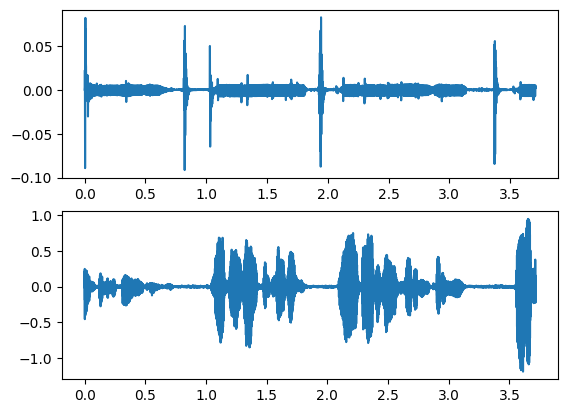

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.subplot(2, 1, 1)
t = np.arange(outputs.shape[1]).astype(np.float64) / 44100
plt.plot(t, outputs[1])
plt.subplot(2, 1, 2)
t = np.arange(batch.shape[1]).astype(np.float64) / 44100
plt.plot(t, batch[1])

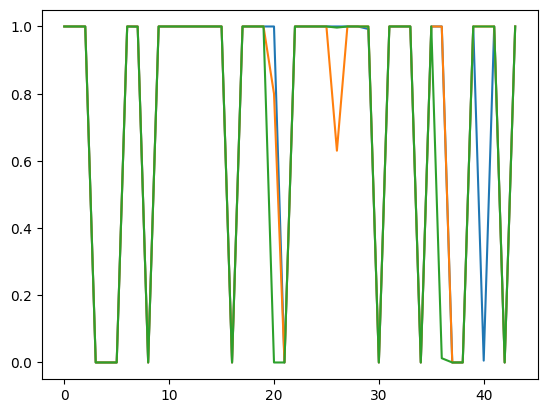

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(control[2, 5:, 201])
plt.plot(control[0, 5:, 201])
plt.plot(control[1, 5:, 201])

In [6]:
import IPython.display as ipd
ipd.Audio(data=batch[0], rate=22050)

In [7]:
import IPython.display as ipd
ipd.Audio(data=outputs[0], rate=22050)

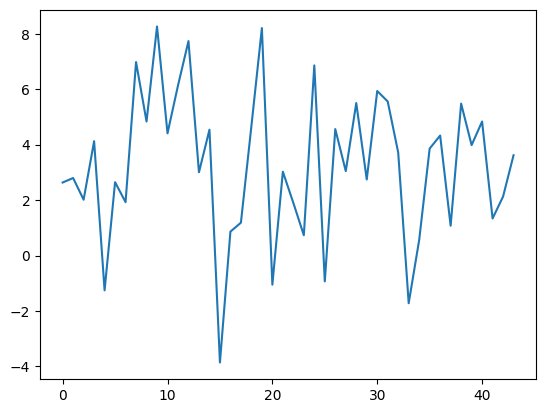

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(unnormalized[0, 5:, 10])

In [65]:
def dummy_data(N=44, T=2000, M=100):
    import numpy as np

    X = np.random.normal(size=(T, N + 5))
    w = np.hamming(M)
    w = w / np.sum(w)
    Y = X[M - 1:, :] * w[0]
    for i in range(1, M):
        # print(X[M-1-i:-i, :].shape)
        Y = Y + X[M-1-i:-i, :] * w[i]
    X = Y
    del Y

    X[:, 0] = X[:, 0] > -.1  # voiced
    X[:, 1] = np.clip(X[:, 1] * 30 + 140 + (44 - N) * 16, 60, 250)  # frequency
    X[:, 2:4] = np.clip(X[:, 2:4] * 5 + 0.7, 0.0, 1.0)  # tenseness
    X[:, 3] = X[:, 2] ** 0.8  # loudness
    X[:, 4] = np.clip(X[:, 4] * 2 + 0.1, 0.01, 0.4)  # velum
    X[:, 6:-1] = (X[:, 5:-2] + X[:, 6:-1] + X[:, 7:]) * 2 + 3.
    X[:, 5:] = np.clip(X[:, 5:], 0., 3.)

    return X

(44,)


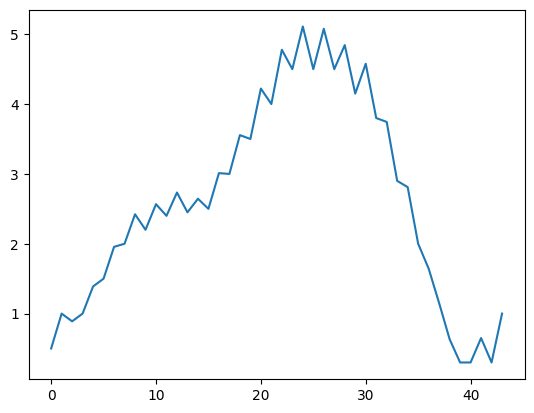

In [66]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array([
    float(x) for x in "5 10 20 24 25 35 45 45 38 20 3 10".split()
]) / 10.
y0 = (2 * x[:-2] - x[2:]) / 9 + x[1:-1]
y1 = x[1:-1]
y2 = (2 * x[2:] - x[:-2]) / 9 + x[1:-1]
y3 = (x[2:] + x[1:-1]) / 2
y = np.stack([y0, y1, y2, y3]).T.flatten()
y = np.concatenate([x[:2], y, x[-2:]])
#x = np.sqrt(x)
print(y.shape)
plt.plot(y)
D = np.sqrt(y)

In [71]:
from voice100_pinktrombone import PinkTrombone
N = 44
N = 39
pt = PinkTrombone(N)
data = dummy_data(N)
#data[:, -44:] = D[None, :]
idx = np.round(np.arange(N) * 43 / (N - 1)).astype(int)
data[:, -N:] = D[None, idx]
audio = pt(data)

In [72]:
import IPython.display as ipd
ipd.Audio(data=audio, rate=44100)